In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *

In [ ]:
## Read in the data
raw_dat=load_endaq_log("data/accel_cal_")

In [4]:

## Downsample the accerometer measurements
dfIMU=raw_dat['accIMU'].resample('30ms').apply(np.mean)
df8=raw_dat['acc8'].resample('30ms').apply(np.mean)
df16=raw_dat['acc16'].resample('30ms').apply(np.mean)


## inject the IMU sensor timestamps and interpolate
df8 = df8.reindex(df8.index.union(dfIMU.index)).interpolate()
df16=df16.reindex(df16.index.union(dfIMU.index)).interpolate()

## Slice out only the synchronous estimates
df8=df8.loc[dfIMU.index]
df16=df16.loc[dfIMU.index]

## Reshape into matrix form for calculations
ts=df8.index.to_numpy(dtype=np.float32)/1e9
mat8=df8.T.to_numpy()
mat16=df16.T.to_numpy()
matIMU=dfIMU.T.to_numpy()


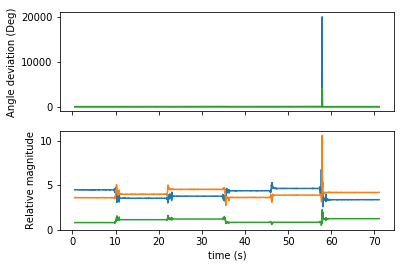

In [5]:
## All 3 accelerometers should be measuring the same magnitude and direction
## Compare compare the relative measures to check for discrepancies

fig=plt.figure()
axs=fig.subplots(2,1,sharex=True)

## use small angle approximation: sin(q) ~ q ~ |a x b|^2 / |a|^2 |b|^2 
q8IMU=axb2(matIMU/np.sum(matIMU**2,axis=0),mat8/np.sum(mat8**2,axis=0),sumall=False)
q816=axb2(matIMU/np.sum(matIMU**2,axis=0),mat16/np.sum(mat16**2,axis=0),sumall=False)
q16IMU=axb2(mat16/np.sum(mat16**2,axis=0),mat8/np.sum(mat8**2,axis=0),sumall=False)

axs[0].set_ylabel("Angle deviation (Deg)")
axs[0].plot(ts,(180/pi)*q8IMU)
axs[0].plot(ts,(180/pi)*q816)
axs[0].plot(ts,(180/pi)*q16IMU)

## Plot the magnitude differences
axs[1].set_ylabel("Relative magnitude")
axs[1].set_xlabel("time (s)")
w8IMU=np.sum(matIMU**2,axis=0)/np.sum(mat8**2,axis=0)
w816=np.sum(mat16**2,axis=0)/np.sum(mat8**2,axis=0)
wIMU16=np.sum(mat16**2,axis=0)/np.sum(matIMU**2,axis=0)
axs[1].plot(ts,w8IMU)
axs[1].plot(ts,w816)
axs[1].plot(ts,wIMU16)


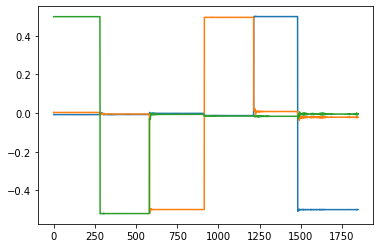

In [6]:
### Select the stable periods only periods
intervals=[\
          (0,9),\
          (11,20),\
          (23,33),\
          (36.5,45.5),\
          (47,55),\
          (59,70),\
          ]          
t_select,acc_select=idx_filter(ts,mat8,intervals)
plt.plot(acc_select[0,:])
plt.plot(acc_select[1,:])
plt.plot(acc_select[2,:])

In [8]:
def cal_matrix(params):
    return R(params[3:6]).dot(np.diag(params[0:3]))

def MeanSqError(a,b):
    return 3*np.mean(( a-b) **2 )

In [7]:
func=MeanSqErrorFunc(mat8,matIMU)

In [ ]:
### Calibration doesnt seem to work??

## Calibrate with rotation and scaling simultaneously
scale=[1,1,1]
lie_vec=np.array([0.00,0,0])
#calibration_matrix=np.diag(scale).dot(R(lie_vec))
#print(calibration_matrix)
func=calibration_cost(mat8,matIMU)

params=minimize(func,[1,1,1,0,0,0])
scale0=params.x[0:3]
lie_vec0=params.x[3:6]

matIMU_cal=cal_matrix(params.x).dot(matIMU)
print(cal_matrix(params.x))


### Initial input
w8IMU=np.sum(matIMU**2,axis=0)/np.sum(mat8**2,axis=0)
q8IMU=axb2(matIMU/np.sum(matIMU**2,axis=0),mat8/np.sum(mat8**2,axis=0),sumall=False)

### corrected input
w8IMU0=np.sum(matIMU_cal**2,axis=0)/np.sum(mat8**2,axis=0)
q8IMU0=axb2(matIMU_cal/np.sum(matIMU**2,axis=0),mat8/np.sum(mat8**2,axis=0),sumall=False)


plt.subplot(2,1,1)
plt.plot(ts,(180/pi)*q8IMU)
plt.plot(ts,(180/pi)*q8IMU0)

plt.subplot(2,1,2)
plt.plot(ts,w8IMU)
plt.plot(ts,w8IMU0)